# Keypoints

💻 The multi-head attention mechanism is a crucial component of the Transformer architecture, and understanding its theory and implementation is essential for coding it effectively.

💡 The multi-head attention system generates multiple attention matrices, each representing a probability distribution, to capture different aspects of the input sequence.

🧠 The head dimension in multi-head attention exists because it combines the query, key, and value vectors, allowing for parallel operations on the sequences.

🧯 Combining multiple heads in a transformer neural network allows them to communicate with each other, resulting in a more context-aware output vector.


# Multihead Attention

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512
x = torch.randn((batch_size, sequence_length, input_dim)) # x : bt_size, seq_len, input_dim
x.size()

torch.Size([1, 4, 512])

输入数据形状为 `(batch_size, sequence_length, input_dim)`。这表示在每个epochs中，有 batch_size 个样本，每个样本是一个长度为 sequence_length 的序列，每个元素的维度为 input_dim。

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

**问题：为什么要定义一个全连接层，而且输出维度为什么是 3 * d_model？**

答案：因为需要从同一个输入 x 生成三个不同的向量：查询（Query）、键（Key）和值（Value）。这三个向量都通过 qkv_layer 生成，所以 qkv_layer 的输出实际上是这三个向量的集合。(一次生成，后续分开)

In [5]:
qkv = qkv_layer(x)  # linear只有最会维度进行变化 （*，H_in）---> (*,H_out)
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

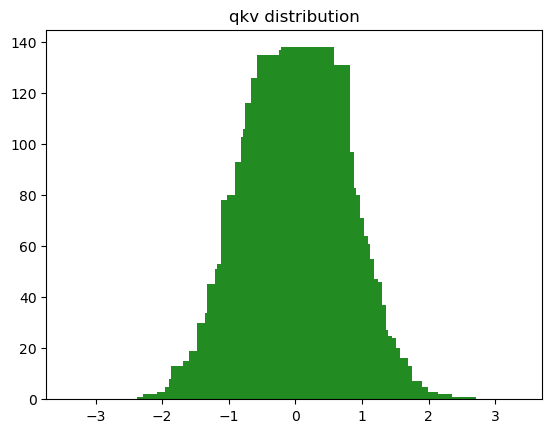

In [6]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins = 200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) *3
plt.bar(x_val, y_val, align='center',color=['forestgreen'])
plt.title('qkv distribution')

**问题：为什么要查看 qkv 的分布？**

答案：查看 qkv 的分布有助于我们理解模型的内部状态和行为。例如，如果分布非常偏斜或集中在某个特定的范围内，那么可能需要调整模型参数或使用不同的初始化策略。此外，这也可以帮助我们调试模型，确认是否有意外的行为（如值的爆炸或消失）。

**问：qkv只是一个[1, 4, 1536]第向量，如何计算分布的？**

torch.histc 函数会将张量视为一个一维的数据流，并对所有的数据点进行统计。

为了更好地理解这个过程，我们可以将其拆解为以下步骤：

首先，torch.histc 函数会将 qkv 张量中的所有元素拉平成一个一维的数组。在例子中，得到一个具有 1 * 4 * 1536 = 6144 个元素的数组。
接着，torch.histc 函数会对这个数组中的元素进行分箱统计。bins 参数定义了分箱的数量，min 和 max 参数定义了分箱的范围。在你的例子中，这将把所有的元素分到 200 个箱子中，每个箱子的范围是 (-3, 3)。
最后，torch.histc 函数会返回一个数组，其中每个元素表示对应箱子中的元素数量。


In [7]:
num_heads = 8
head_dim = d_model // num_heads # 1536/8 = 192
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)
qkv.shape

torch.Size([1, 4, 8, 192])

qkv 被重塑和拆分成 num_heads 个头，每个头的维度是 head_dim。每个头使用的 q、k、v 是全体 q、k、v 经过线性变换后的部分数据，而不是直接从原始的 q、k、v 中取一部分

**问题：为什么要改变 qkv 的形状？**

答案：在多头注意力机制中，输入的 d_model 维度的数据会被分成多个“头”，每个头处理一部分信息。这样可以让模型在处理输入时更加灵活，因为每个头可以学习并专注于捕获不同的信息

**问题：为什么在最后一个维度上将数据划分为了 num_heads 个部分？**

答案：在深度学习模型中，最后一个维度通常用来表示数据的特征，而前面的维度则用来表示数据的结构。在这个上下文中，num_heads 是我们的“头”的数量，每个“头”都需要处理一部分特征。因此，我们在最后一个维度上将数据划分为了 num_heads 个部分。

这样做的好处是，可以让我们在后续的计算中，更方便地处理每个“头”的数据。例如，当我们需要计算每个“头”的注意力权重时，我们可以直接对最后一个维度（即 3 * head_dim）进行操作，而不需要关心“头”的数量。

In [8]:
qkv = qkv.permute(0,2,1,3)
qkv.shape

torch.Size([1, 8, 4, 192])

通过将 qkv 的维度重排列为 `(batch_size, num_heads, sequence_length, 3 * head_dim)`，我们可以更方便地处理每个头的数据，因为现在每个头的数据都在连续的内存位置中。

In [9]:
q, k, v = qkv.chunk(3, dim = -1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

# Self Attention for multiple heads

For a single head:

$$
\begin{aligned}
\text { self attention } & =\operatorname{softmax}\left(\frac{Q \cdot K^T}{\sqrt{d_k}}+M\right) \\
\text { new } \mathrm{V} & =\text { self attention. } V
\end{aligned}
$$


In [10]:
import math

d_k = q.size()[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)  # 1，8，4，64 * 1，8，64，4 ---> 1,8,4,4
scaled.shape

torch.Size([1, 8, 4, 4])

**问题：为什么要计算缩放的点积注意力，以及为什么要对结果进行缩放？**

答案：在 Transformer 模型的注意力机制中，我们使用查询 `q` 和键 `k` 的点积来计算注意力权重。然而，当查询和键的维度 $d_k$ 较大时，点积的结果可能会非常大，这会导致 softmax 函数（通常用于计算注意力权重）在反向传播时梯度消失，从而影响模型的训练。

为了解决这个问题，我们引入了缩放因子 $1/\sqrt(d_k)$。这个缩放因子可以确保点积的结果在一个合理的范围内，从而避免 softmax 函数的梯度消失问题。

scaled 的形状 `(batch_size, num_heads, sequence_length, sequence_length)`。因为这是在最后两个维度上进行的矩阵乘法，即对于每个头和每个批次的数据，我们都计算了所有查询和键的点积。

In [11]:
# 补充
y = torch.randn(2, 3)
print(f"y: {y}")
print(f"y transpose: {torch.transpose(y, 1, 0)}")

y: tensor([[ 0.9286, -0.2131, -1.0884],
        [ 1.2531,  0.7147, -0.6907]])
y transpose: tensor([[ 0.9286,  1.2531],
        [-0.2131,  0.7147],
        [-1.0884, -0.6907]])


**问题：为什么多维度张量需要使用 PyTorch 的 transpose 或 permute 函数进行转置，而不能使用 NumPy 的 T 属性？**

答案：NumPy 的 T 属性和 transpose 函数在处理二维数组（即矩阵）时表现得很好，它们可以将二维数组的行和列进行交换。然而，对于高于二维的数组，T 属性只会反转维度的顺序，这可能并不是我们想要的结果。

例如，对于一个形状为 (a, b, c) 的三维数组，T 属性会得到一个形状为 (c, b, a) 的数组。但在许多情况下，我们可能希望交换其他两个维度，如 (a, c, b) 或 (b, a, c)，这时就需要使用 transpose 或 permute 函数了。

PyTorch 的 transpose 和 permute 函数提供了更强大的功能，它们可以交换张量的任意两个维度，或者重新排列所有维度的顺序。

In [12]:
## 生成masked
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
print(f"All head masked: {mask}")
print(f"Single head masked: {mask[0][1]}") # mask for input to a single head

All head masked: tensor([[[[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
          [0., 0., 0., 0.]],

         [[0., -inf, -inf, -inf],
          [0., 0., -inf, -inf],
          [0., 0., 0., -inf],
     

**问题：mask[0][1] 具体表示什么？**

答案：在这个上下文中，mask[0][1] 用于选择 mask 张量中第一个批次（batch）的第二个头（head）的遮罩。在多头注意力机制中，每个批次包含多个头，每个头都有自己的查询、键和值向量，以及对应的遮罩。这里，mask[0][1] 就是选择了第一个批次的第二个头的遮罩。

In [13]:
(scaled + mask) [0][0] 

tensor([[ 0.2548,    -inf,    -inf,    -inf],
        [ 0.7148,  0.7982,    -inf,    -inf],
        [ 0.0151,  0.1546,  0.6325,    -inf],
        [-0.2733, -0.6332, -0.1531,  0.1882]], grad_fn=<SelectBackward0>)

**问题：为什么需要创建这样的 mask 张量，它的作用是什么？**

答案：这个 mask 张量是用于遮罩序列的一部分，防止模型看到序列的未来信息。在自然语言处理任务中，特别是在训练语言模型时，我们希望模型在预测下一个词时，只能看到当前词及其之前的词，而不能看到未来的词。这样的遮罩可以帮助我们实现这个目标。

具体来说，mask 张量的上**三角部分是负无穷，表示序列的未来信息；下三角部分是零**，表示序列的当前和过去的信息。当我们在计算注意力权重时，将这个 mask 添加到 scaled 上，因为 softmax 函数对于负无穷的输入会输出零，所以模型就无法看到序列的未来信息了。

In [14]:
scaled = scaled + mask # multi head  attention score matrix with masked

In [15]:
attention = F.softmax(scaled, dim=-1)  # scaled to [0, 1]
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4792, 0.5208, 0.0000, 0.0000],
        [0.2498, 0.2871, 0.4631, 0.0000],
        [0.2266, 0.1582, 0.2556, 0.3596]], grad_fn=<SelectBackward0>)

In [16]:
print(f"attention size: {attention.size()}, values size: {v.size()}")

attention size: torch.Size([1, 8, 4, 4]), values size: torch.Size([1, 8, 4, 64])


In [17]:
values = torch.matmul(attention, v) # attention score * values
values.shape

torch.Size([1, 8, 4, 64])

# Function

In [18]:
import math

def scaled_dot_product(q, k, v, mask=None):
    d_k=q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1,-2))/math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [19]:
values, attention = scaled_dot_product(q, k, v, mask=None)
attention.shape

torch.Size([1, 8, 4, 4])

In [20]:
attention[0][0]

tensor([[0.2764, 0.2697, 0.2149, 0.2389],
        [0.2994, 0.3255, 0.1295, 0.2455],
        [0.2013, 0.2314, 0.3732, 0.1941],
        [0.2266, 0.1582, 0.2556, 0.3596]], grad_fn=<SelectBackward0>)

In [21]:
values.size()

torch.Size([1, 8, 4, 64])

In [22]:
values = values.reshape(batch_size, sequence_length, num_heads*head_dim)
values.size()

torch.Size([1, 4, 512])

In [23]:
linear_layer = nn.Linear(d_model,d_model)
linear_layer

Linear(in_features=512, out_features=512, bias=True)

In [24]:
out = linear_layer(values)
out.shape

torch.Size([1, 4, 512])

In [25]:
out

tensor([[[-0.3412,  0.2449,  0.2114,  ..., -0.2294,  0.0139,  0.0105],
         [-0.1401,  0.0268, -0.0720,  ..., -0.1523,  0.2122,  0.0164],
         [-0.0465,  0.1051, -0.0417,  ...,  0.1026,  0.1103, -0.0321],
         [-0.0727, -0.0463,  0.0377,  ..., -0.1145,  0.2986,  0.2640]]],
       grad_fn=<ViewBackward0>)

# (All) MultiheadAttention

In [26]:
import torch
import torch.nn as nn
import math

def scaled_dot_product(q, k ,v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads

        self.head_dim = d_model //num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
    
    def forward(self, x, mask = None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")

        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")

        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3*self.head_dim)
        print(f"qkv.size(): {qkv.size()}")

        qkv  = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")

        q, k, v = qkv.chunk(3, dim = -1)
        print(f"q size:{q.size()}, k size:{k.size()}, v size:{v.size()}")

        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention size: {attention.size()}")

        values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim)
        print(f"values.size(): {values.size()}")

        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out


# Input without mask

In [27]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)


x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size:torch.Size([30, 8, 5, 64]), k size:torch.Size([30, 8, 5, 64]), v size:torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention size: torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [28]:
out

tensor([[[ 7.5284e-02,  1.2722e-01,  2.4985e-01,  ..., -2.1212e-01,
          -1.4147e-01,  5.2860e-02],
         [-1.2464e-01, -1.4993e-01, -1.1479e-01,  ..., -2.9906e-02,
          -6.3602e-03,  1.9076e-01],
         [-1.1769e-01, -9.4000e-02,  9.0091e-02,  ...,  8.0865e-02,
           4.6137e-02, -1.1308e-01],
         [ 8.9524e-02,  5.5354e-02, -3.9023e-02,  ...,  3.1260e-02,
          -1.2758e-01, -3.8482e-02],
         [-1.5184e-01, -5.3139e-02, -1.8266e-01,  ..., -1.0104e-01,
           3.0766e-01,  1.0210e-01]],

        [[-5.6526e-02,  3.8834e-01, -1.2390e-02,  ..., -5.9704e-02,
           2.3768e-01, -2.9467e-02],
         [ 1.2905e-01,  2.2574e-02,  7.2760e-02,  ...,  3.4676e-03,
          -6.2535e-02,  1.4201e-01],
         [ 1.7856e-01, -4.9391e-02,  6.3659e-02,  ..., -1.6452e-01,
          -9.0021e-02, -1.3106e-01],
         [ 1.4727e-01,  9.4759e-03, -2.9079e-01,  ...,  5.3035e-02,
          -1.2689e-01,  2.4708e-01],
         [-2.3948e-02,  3.7071e-02, -8.5224e-02,  ...

# Input with mask

In [29]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
# x = torch.randn((batch_size, sequence_length, input_dim))  add masked

model = MultiheadAttention(input_dim, d_model, num_heads)

mask = (torch.triu(torch.ones((batch_size, 1, sequence_length, sequence_length))) == 1).transpose(-1, -2)
mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

out = model.forward(x, mask)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size:torch.Size([30, 8, 5, 64]), k size:torch.Size([30, 8, 5, 64]), v size:torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention size: torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])


In [30]:
out

tensor([[[ 1.3427e-01,  1.8508e-03,  3.1447e-01,  ..., -3.6402e-01,
           1.1125e-01, -2.2567e-02],
         [-1.1818e-01,  8.7459e-02,  1.8139e-01,  ...,  1.9198e-01,
           9.0766e-02,  3.3462e-01],
         [ 3.8551e-01, -2.0970e-02, -1.3621e-02,  ...,  6.1666e-02,
          -1.3019e-02,  1.5994e-01],
         [ 1.2894e-01,  2.1139e-01, -6.2112e-02,  ...,  5.1420e-02,
           8.0267e-02,  1.4966e-01],
         [-6.8595e-01,  3.3024e-01, -1.0399e-01,  ..., -3.8271e-01,
           8.9425e-02, -1.1681e-01]],

        [[ 8.5313e-02,  2.0682e-01,  9.9087e-03,  ..., -1.1775e-01,
          -2.0251e-01, -3.3115e-01],
         [ 4.1339e-01,  8.4770e-02,  1.2837e-03,  ...,  4.0821e-01,
          -1.6438e-01,  1.2384e-01],
         [-5.5205e-02, -5.0865e-01,  2.9354e-01,  ...,  4.7963e-01,
          -1.7520e-01, -2.5475e-02],
         [ 2.2127e-01,  1.0342e-01, -2.5137e-01,  ...,  3.1584e-01,
          -5.5105e-02, -3.1359e-01],
         [-7.9030e-02, -1.8711e-01,  6.1984e-02,  ...

# PyTorch API
## torch.nn
- [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)：应用线性变换到输入数据：y = xA^T + b

## torch
- [torch.reshape](https://pytorch.org/docs/stable/generated/torch.reshape.html?highlight=reshape#torch.reshape)：将输入张量的形状改变为给定的形状
- [torch.permute](https://pytorch.org/docs/stable/generated/torch.permute.html?highlight=permute#torch.permute)：返回一个输入张量的视图，该视图的维度以特定的顺序重新排列
- [torch.chunk](https://pytorch.org/docs/stable/generated/torch.chunk.html?highlight=chunk#torch.chunk)：将输入张量切割为特定数量的块
- [torch.matmul](https://pytorch.org/docs/stable/generated/torch.matmul.html?highlight=torch+matmul#torch.matmul)：执行两个张量之间的矩阵乘法
- [torch.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html?highlight=torch+transpose#torch.transpose)：返回一个输入张量的转置，即互换两个维度
- [torch.full](https://pytorch.org/docs/stable/generated/torch.transpose.html?highlight=torch+full#torch.full)：返回一个形状为 size，填充值为 fill_value 的张量
- [torch.triu](https://pytorch.org/docs/stable/generated/torch.transpose.html?highlight=torch+triu#torch.triu)：返回一个张量，其中包含了输入矩阵的上三角部分，其他位置设为0

## torch.nn.functional
- [torch.nn.functional.softmax](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html?highlight=softmax#torch.nn.functional.softmax)：对输入数据进行 softmax 操作，这是一个常用于将实数向量规范化为概率分布的操作